# Transportation Flexibility: Simulations
A computational analysis of transportation cost for a priori routes with overlapped assignment.

## Setup

In [1]:
import sys
import numpy as np
import pandas as pd
import math
import random
import time
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
import matplotlib.pyplot as plt
from collections import OrderedDict
from concorde.tsp import TSPSolver
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
print(sys.version)

3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]


## Special Classes

In [2]:
##### CUSTOMER #####
class Customer:
    """
    A class used to represent a single customer node.
    
    Initialization Parameters:
    ----------
    ID : identifying label (str)
    x : x-coordinate of the customer location (float)
    y : y-coordinate of the customer location (float)
    d : customer's realized demand 

    Other Attributes
    ----------
    dsplit : a dictionary of (truck ID, demand filled) pairs to track split demand
    loc : the (x,y) location of the customer (tuple)
    type : the node class, i.e. customer
    
    """
    
    def __init__(self, x, y, ID, d):

        self.ID = str(ID)
        self.x = float(x)
        self.y = float(y)
        self.d = float(d)
        self.dsplit = {}
        self.loc = (self.x,self.y)
        self.type = 'customer'
      
    
##### DEPOT #####
class Depot:
    """
    A class used to represent a single depot node.
    
    Initialization Parameters
    ----------
    ID : identifying label (str)
    x : x-coordinate of the customer location (float)
    y : y-coordinate of the customer location (float)

    Other Attributes
    ----------
    loc : the (x,y) location of the customer (tuple)
    type : the node class, i.e. depot
    
    """
    
    def __init__(self, ID, x, y):
        
        self.ID = str(ID)
        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.type = 'depot'

        
##### ROUTE #####
class Route:
    """
    A class used to represent a delivery route
    
    Initialization Parameters:
    ----------
    sequence : dictionary of position and customer node objects in greater network
    ID : identifying label (str)  

    Other Attributes
    ----------
    n : number of customers visited on route
    d : total demand filled for route customers (should be adjusted if customer demands are split)
    customers : ordered list of customer objects in route
    type : the node class, i.e. route
    
    """
    
    def __init__(self, sequence, ID):

        self.ID = ID
        self.d = sum([cust.d for cust in list(sequence.values())])
        self.sequence = sequence
        self.customers = list(sequence.values())
        self.n = len(sequence)
        self.type = 'route'


## Visualization Functions

In [3]:
def plot_nodes(customers, depots=None):
    """
    Takes in dictionary of customer objects and an optional dictionary of depot objects and plots node locations.
    """
    
    # Combined dictionary of depot and customer nodes
    nodes = {}
    if depots != None:
        nodes.update(depots)
    nodes.update(customers)
    
    x = [nodes[i].x for i in nodes]
    y = [nodes[i].y for i in nodes]
    color = ['black' if nodes[i].type == 'customer' else 'red' for i in nodes]
    plt.scatter(x, y, c=color)
    plt.show()
    
def plot_TSP(customers, X, showLabels=False):
    """
    Extract and plots the optimal TSP path through customers. Receives as input a dictionary of customer objects and a dictionary of 
    routing decisions (i.e., (i,j) customer ID tuples and 0-1 decisions for routing) from the Gurobi model.
    """
    
    # Select an arbitrary customer to initiate the path
    i = list(customers.keys())[0]
    
    # Record the x and y coordinates of that customer
    locslist_x = [customers[i].x]
    locslist_y = [customers[i].y]
    
    # Record that you have visited one customer already
    n_done = 1
    
    # While you have not yet visited all customers (i.e., full circle not complete)
    while n_done <= len(customers):
        
        # Find next customer along the optimal TSP path
        for j in customers:
            if ((i,j) in X) and (round(X[(i,j)]) == 1):  
                
                # Record the x and y coordinates of that customer
                locslist_x.append(customers[j].x)
                locslist_y.append(customers[j].y)
         
                i = j     # Set the last visited customer to this customer     
                n_done += 1 # Increase the number of customers visited
                break # Break this for loop since you found the model's selected customer

    # Plot customer locations
    x = [customers[i].x for i in customers]
    y = [customers[i].y for i in customers]
    plt.scatter(x, y)
    
    # Plot the TSP path through the customers
    plt.plot(locslist_x, locslist_y, 'ro-')
    
    if showLabels:
        # Add customer labels
        for i in range(len(customers)):
            cust = list(customers.keys())[i]
            label = customers[cust].ID
            plt.annotate(label, # Label text
                         (x[i],y[i]), # Point to label
                         textcoords="offset points",
                         xytext=(0,5), # Distance from text to points (x,y)
                         ha='center')

    plt.show()
def plot_routes(customers,depots,X,showLabels=False):
    """
    Plot routes with different colors for different trips. Takes in dictionary of customer objects, dictionary of depot objects,
    and dictionary of routing variables (i.e., edge decisions) returned from the Gurobi model. Plots customer IDs if showLabels is True.
    """
    
    # Combined dictionary of depot and customer nodes
    nodes = {}
    nodes.update(depots)
    nodes.update(customers)

    
    # Derive route sequences
    for d in depots:
        for j in customers:
            if round(X[(d,j)]) == 1:
                mylist = [d,j]
                locslist_x = [nodes[d].x, nodes[j].x]
                locslist_y = [nodes[d].y, nodes[j].y]

                jj = j

                while not jj == d:
                    for i in nodes:
                        if round(X[(jj,i)]) == 1:
                            mylist.append(i)
                            locslist_x.append(nodes[i].x)
                            locslist_y.append(nodes[i].y)
                            jj = i
                            break

                # Plot VRP solution
                plt.plot(locslist_x, locslist_y, 'ko-')
    
    # Plot depots
    x = [depots[i].x for i in depots]
    y = [depots[i].y for i in depots]
    plt.plot(x, y, color='green', markersize=10, marker='s')
    
    # Plot customers with zero demand
    x = [customers[i].x for i in customers if customers[i].d==0]
    y = [customers[i].y for i in customers if customers[i].d==0]
    plt.plot(x, y, 'ko', fillstyle='none')
    
    plt.ylim(ymin=0,ymax=100)
    plt.xlim(xmin=0,xmax=100)
    
    if showLabels:
        # Add customer labels
        for i in range(len(customers)):
            cust = list(customers.keys())[i]
            plt.annotate(customers[cust].ID, # Label text
                         (customers[cust].x,customers[cust].y), # Point to label
                         textcoords="offset points",
                         xytext=(0,5), # Distance from text to points (x,y)
                         ha='center')
            
    plt.show()

## Helper Functions

In [4]:
def calc_dist_matrix(nodes):
    """
    Compute pairwise distance matrix. Takes in dictionary of objects with locations (e.g. customers and depots).
    Returns dictionary of Euclidian distances between all possible node pairs. TO DO: Update function name to dict.
    
    """
    return dict(
        [((i,j), math.sqrt((nodes[i].x-nodes[j].x)**2
                           + (nodes[i].y-nodes[j].y)**2))
          for i in nodes
          for j in nodes]
    )

def get_edge_list(route, depot):
    """
    Creates list of Route edges. Receives Route object and Depot object as inputs and returns a list of tuples of NODE IDs
    representing edges between nodes in a route.
    """

    # List of node IDs (positions)
    positions = [cust.ID for cust in route.customers]

    # Replace position of 0 with depot ID
    for i in range(len(positions)):
        if positions[i]==0:
            positions[i]=depot.ID  
    
    # First edge is between depot and first customer
    route_edges = [(depot.ID, positions[0])]
    
    # Create edges between customers
    for i in range(route.n-1):
        route_edges.append((positions[i], positions[i+1]))
        
    # Create final edge to depot
    route_edges.append((positions[route.n-1], depot.ID))
    
    return route_edges

def get_sequence(customers, X):
    """
    Creates a customer seqence by linking together selected edges. Takes in dictionary of customer objects and dictionary of 
    routing edge decisions (i.e., (i,j) customer ID tuples and 0-1 decisions for routing). Outputs a dictionary with (position in
    sequence, customer object) as the key-value pairs.
    """
    
    # Select first customer object to initiate path
    i = list(customers.keys())[0]
    sequence = [customers[i]]

    # Record that you have visited one customer already
    n_done = 1
    
    # While you have not yet visited all customers...
    while n_done <= len(customers):
        
        # Find next customer along the given path
        for j in customers:
            if ((i,j) in X) and (round(X[(i,j)]) == 1):  
                sequence.append(customers[j]) # Add customer to sequence
                i = j # Set the last visited customer to this customer
                n_done += 1 # Increase the number of customers visited           
                break # Break this for loop since you found the model's selected customer
                
    return dict([(n+1, sequence[n]) for n in range(len(sequence)-1)])

                
def get_breakpoint_indices(demands, Q):
    """
    Takes in list of demands and an integer capacity, and returns a list of indices based on the demand list
    where the truck will detour to the depot to refill and then return to the route.
    """
    
    indices = []
    k = 1 # Scalar for capacity to track number of refill trips
    agg = 0 # Tracks aggregate route demand filled
    
    for i in range(0,len(demands)):
        
        rem_demand = demands[i]
        while rem_demand > 0:

            if agg < k*Q and k*Q < agg+demands[i]:
                indices.append(i) # breakpoint
                indices.append(i) # returnpoint
                k+=1
            elif agg < k*Q and k*Q == agg+demands[i]:
                if i < len(demands)-1:
                    indices.append(i) # breakpoint
                    indices.append(i+1) # returnpoint
                k+=1
            elif agg == (k-1)*Q and k*Q == agg+demands[i]:
                if i < len(demands)-1:
                    indices.append(i) # breakpoint
                    indices.append(i+1) # returnpoint
                k+=1
            else:
                pass

            rem_demand -= Q
        
        agg += demands[i]
            
    return indices

### FOR PRIMARY / OVERLAPPING
def get_primary_routes(customers, tau, route_size):
    """
    Creates primary fixed routes. Receives as input a dictionary of customer objects, a sequence (dictionary) of customer objects,
    and the number (int) of customers to include in each route. Outputs a dictionary of route objects with route number as the key
    and the object as the value.
    """
    
    M = int(len(tau)/route_size) # Number of routes
    routes = {}
    
    for r in range(M):
        sub_seq = dict([(i+1, tau[i+1]) for i in range(r*route_size, (r+1)*route_size)])
        routes[r+1] = Route(sub_seq, r+1)        
    return routes

### FOR OVERLAPPING
def get_start_position(sub_tau,capacity):
    """
    Determines the position of the customer whose demand cannot be completely filled. Receives a dictionary with sequence of customer objects and 
    an integer representing total demand allowed to be filled. Returns a tuple with (1) the position of the customer whose demand cannot be completely filled
    and (2) the amount of demand for the next truck to fill at the customer. Returns (0,0) if the truck doesn't need to leave the depot.
    """
    positions = list(sub_tau.keys())

    demand = 0 # Demand counter
    j = 0 # Key tracker
    i = 0 # Index counter
    
    # Fill customers' demand until capacity exhausted
    while demand <= capacity:
        
        if i < len(positions):
            
            j = positions[i]
            demand += sub_tau[j].d # Add in demand of customer number i
            i+=1
        
        else:
            return (0,0)

    
    return (positions[i-1], demand-capacity) 

def get_routing_solution(tau):
    """Given a customer sequence (dictionary of position-customer pairs), returns the equivalent dictionary of routing decision variables."""
    new_X = dict([((tau[i].ID,tau[j].ID), 0)  for i in tau for j  in tau])
    for i in range(len(tau)-1):
        start_cust = tau[list(tau.keys())[i]]
        next_cust = tau[list(tau.keys())[i+1]]
        new_X[(start_cust.ID,next_cust.ID)] = 1
    # Add final closing arc
    new_X[(next_cust.ID,tau[list(tau.keys())[0]].ID)] = 1
    return new_X

def get_demand_points(customers):
    """Given a dictionary of customer objects, returns a dictionary of equivalent customers with binary demands."""
    demand_points = {}
    for c in customers:
        for i in range(int(customers[c].d)):
            demand_points[customers[c].ID+'_'+str(i+1)] = Customer(ID = customers[c].ID+'_'+str(i+1),
                                                                   x = customers[c].x,
                                                                   y = customers[c].y,
                                                                   d = 1)
    return demand_points

## Traveling Salesman Problem (TSP)

#### Concorde TSP Solver

In [5]:
def solve_Concorde_TSP(customers):
    
    x_data = [customers[c].x for c in customers]
    y_data = [customers[c].y for c in customers]
    solver = TSPSolver.from_data(x_data, y_data, 'EUC_2D')
    start = time.time()
    solution = solver.solve()
    end = time.time()
    obj = solution.optimal_value
    solution_IDs = [list(customers.keys())[x] for x in solution.tour]
    tau = dict([(i+1, customers[c]) for i,c in zip(range(len(customers)), solution_IDs)])
    return obj, get_routing_solution(tau), end-start

### Concorde Solver ###
Cost: 803.0
Runtime: 0.3066527843475342


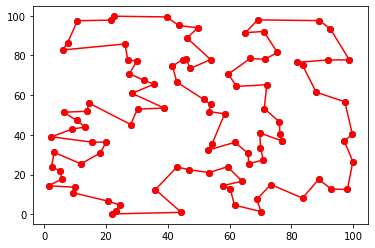

In [6]:
Q = 20
N = 100
area_width = 100
area_height = 100
customers = dict(
    [('Cust_'+str(i+1), Customer(ID = 'Cust_'+str(i+1),
                                 x = random.uniform(0,area_width),
                                 y = random.uniform(0,area_height),
                                 d = random.randint(0,8)))
     for i in range(N)])

print("### Concorde Solver ###")
obj, X, runtime = solve_Concorde_TSP(customers)
print("Cost:", obj)
print("Runtime:", runtime)
plot_TSP(customers, X)

## Vehicle Routing Problem (VRP)

#### Google OR-Tools VRP Solver

Adapted from https://developers.google.com/optimization/routing/cvrp

In [7]:
def solve_OR_Tools_VRP(customers, depots, Q):
    """Solve the CVRP problem."""
    
    def create_distance_matrix(nodes):
        """Createss pairwise distance matrix."""
        distance_matrix = []
        for i in nodes:
            distance_row = []
            for j in nodes:
                distance_row.append(math.sqrt((nodes[i].x-nodes[j].x)**2 + (nodes[i].y-nodes[j].y)**2))
            distance_matrix.append(distance_row)
        return distance_matrix

    def create_data_model(customers, depots, Q):
        """Stores the data for the problem."""
        # Create set of nodes with both depots and customers
        nodes = {}
        nodes.update(depots)
        nodes.update(customers)
        data = {}
        #data['locations'] = [nodes[i].loc for i in nodes]
        data['distance_matrix'] = create_distance_matrix(nodes)
        data['demands'] = [0] + [customers[c].d for c in customers]
        data['vehicle_capacities'] = [Q]*len(customers)
        data['num_vehicles'] = len(customers)
        data['depot'] = 0
        return data


    def print_solution(data, manager, routing, solution):
        """Prints solution on console."""
        total_distance = 0
        total_load = 0
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
            route_distance = 0
            route_load = 0
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route_load += data['demands'][node_index]
                plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                     route_load)
            plan_output += 'Distance of the route: {}m\n'.format(route_distance)
            plan_output += 'Load of the route: {}\n'.format(route_load)
            print(plan_output)
            total_distance += route_distance
            total_load += route_load
        print('Total distance of all routes: {}m'.format(total_distance))
        print('Total load of all routes: {}'.format(total_load))

    def get_routes(solution, routing, manager):
        """Get vehicle routes from a solution and store them in an array."""
        # Get vehicle routes and store them in a two dimensional array whose
        # i,j entry is the jth location visited by vehicle i along its route.
        routes = []
        for route_nbr in range(routing.vehicles()):
            index = routing.Start(route_nbr)
            route = [manager.IndexToNode(index)]
            while not routing.IsEnd(index):
                index = solution.Value(routing.NextVar(index))
                route.append(manager.IndexToNode(index))
            routes.append(route)
        return routes

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    
    ###################
    ### RUN PROGRAM ###
    ###################
    # Return 0 cost if no demands
    if all([customers[cust].d == 0 for cust in customers]):
        return (0, 0, 0)
    
    start = time.time()
    
    # Instantiate the data problem.
    data = create_data_model(customers, depots, Q)
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    end = time.time()
    routes = get_routes(solution, routing, manager)
    #print(routes)
    num_trips = sum(sum(d for d in r)>0 for r in routes)
    return solution.ObjectiveValue(), end-start, num_trips
    """
    # Print solution on console.
    if solution:
        print('Solution found.')
        print('Objective: {}'.format(solution.ObjectiveValue()))
        #print_solution(data, manager, routing, solution)
        for i, route in enumerate(routes):
            print('Route', i, route)
    """

In [8]:
Q = 20
N = 5
area_width = 100
area_height = 100
customers = dict(
    [('Cust_'+str(i+1), Customer(ID = 'Cust_'+str(i+1),
                                 x = random.uniform(0,area_width),
                                 y = random.uniform(0,area_height),
                                 d = random.choice([0,8])))
                                 #d = random.randint(0,8)))
     for i in range(N)])

depots = {"Depot_1": Depot(ID = "Depot_1", x = 50, y = 50)}

demand_points = get_demand_points(customers)
solve_OR_Tools_VRP(demand_points, depots, Q)

(289, 0.10668516159057617, 2)

## Flexible Vehicle Routing

#### Lowerbound

In [8]:
def get_lowerbound(customers, depot, Q):
    """Returns a lowerbound on transportation cost given a dictionary of customer objects,
    a single depot object, and truck capacity Q."""
    
    # Get pairwise distances
    nodes = {}
    nodes.update(depots)
    nodes.update(customers)
    distances = calc_dist_matrix(nodes)
    
    # Return lower bound
    return (2/Q)*sum([customers[i].d*distances[(depot.ID, customers[i].ID)] for i in customers])

#### Full Flexibility

In [10]:
def solve_fully_flexible(tau, customers, depot, Q):
    """
    Determines the cost of vehicle routing and the number of trips needed with fully flexible routes.
    
    INPUTS
    tau : dictionary with customer sequence
    customers : dictionary of customer objects
    depot : SINGLE depot object
    Q : truck capacity (int)
    
    OUTPUTS
    Tuple with (1) circular cost, (2) radial cost, (3) combined cost, and (4) number of trips needed to meet all demand.
    """
    # Get pairwise distances
    nodes = {}
    nodes.update(depots)
    nodes.update(customers)
    distances = calc_dist_matrix(nodes)
    
    # Keep customers with non-zero demand
    nonzero_tau = dict([(i, tau[i]) for i in tau if tau[i].d >0])
    
    # Use bin-packing to determine  route endpoints (list indices)
    demands = [nonzero_tau[i].d for i in nonzero_tau]
    if len(demands) > 0:
        endpoints = [0] + get_breakpoint_indices(demands, Q) + [len(demands)-1]
        assert len(endpoints) % 2 == 0, "Assertion Error: There is not an even number of endpoints."
        num_trips = len(endpoints)/2
    else:
        return (0,0,0,0) # No demands to fill, so no transportation costs or trips
    
    # Use end points to create Routes and calculate costs
    greedy_routes = {}
    circular_costs = []
    radial_costs = []
    total_costs = []
    
    j = 1
    for e in range(0,len(endpoints)-1,2):
        
        # Create new route
        start = endpoints[e] # Position of first customer
        end = endpoints[e+1] # Position of last customer
        sub_seq = dict([(i, nonzero_tau[i]) for i in nonzero_tau if i >= [*nonzero_tau][start] and i <= [*nonzero_tau][end]])
        greedy_routes[j] = Route(sub_seq, j)
        
        # TO-DO: Need to update to accomodate split demand

        # Calculate radial costs at beginning and end of route
        radial = distances[depot.ID, greedy_routes[j].customers[0].ID] + distances[depot.ID, greedy_routes[j].customers[-1].ID]
        radial_costs.append(radial)

        # Calculate circular cost
        route_edges = get_edge_list(greedy_routes[j],depot) # Edge list
        circular = sum([distances[e] for e in route_edges])
        circular -= radial # TEMP FIX: remove radial cost from circular to prevent double counting
        circular_costs.append(circular)
        
        # Total cost
        total_costs.append(circular+radial)
        j+=1
    
    """
    ### Generate report ###
    
    print('N=%s, M=%s, Q=%s \n' %(len(customers),len(greedy_routes),Q))
 
    for j in greedy_routes:
        print("Truck %s Route (pos, d) -->" %j, [(list(greedy_routes[j].sequence.keys())[i],
                                                 greedy_routes[j].customers[i].ID,
                                                 greedy_routes[j].customers[i].d) for i in range(greedy_routes[j].n)])
    print('')
    print('Starting Position (s), Workload (w), Excess Capacity (e), Final Position (f):')
    for j in greedy_routes:
        print('Route %s: s=%s, w=%s, e=%s, f=%s'
              %(j,[*greedy_routes[j].sequence][0],greedy_routes[j].d, Q-greedy_routes[j].d, [*greedy_routes[j].sequence][-1]))
    print('')
    print('Circular Costs --> ', np.round(circular_costs))
    print('Radial Costs --> ', np.round(radial_costs))
    print('Total Costs --> ', np.round(np.add(radial_costs,circular_costs)))

    """

    
    return sum(circular_costs), sum(radial_costs), sum(total_costs), num_trips

#### Primary Routes

In [9]:
def solve_primary(tau, customers, depot, Q, route_size):
    """
    Determines the cost of vehicle routing and the number of trips needed with fixed non-overlapping routes. Assumes M = N/route_size >= 1.
    
    INPUTS
    tau : dictionary with customer sequence
    customers : dictionary of customer objects
    depot : SINGLE depot object
    Q : truck capacity (int)
    route_size: number of customers per route (int)
    
    OUTPUTS
    Tuple with (1) circular cost, (2) radial cost, (3) combined cost, and (4) number of trips needed to meet all demand.
    """
    
    N = len(customers) # Number of customers
    M = int(N/route_size) # Number of trucks (assume N divisible by route_size)
    
    # Create set of nodes with both depots and customers
    nodes = {}
    nodes.update(depots)
    nodes.update(customers)
 
    # Calculate pairwise distance matrix
    distances = calc_dist_matrix(nodes)

    # Create primary routes
    primary_routes = get_primary_routes(customers, tau, route_size)
    
    # Solve each primary route as if fully flexible
    circular_costs = []
    radial_costs = []
    total_costs = []
    num_trips = []
    for j in primary_routes:
        circular, radial, total, trips = solve_fully_flexible(primary_routes[j].sequence, customers, depot, Q)
        circular_costs.append(circular)
        radial_costs.append(radial)
        total_costs.append(total)
        num_trips.append(trips)
    
    return sum(circular_costs), sum(radial_costs), sum(total_costs), sum(num_trips)

#### Overlapped Routes

In [43]:
def solve_overlapped(tau, customers, depot, Q, route_size, k=None):
    """
    Determines the cost of vehicle routing and the number of trips needed with a priori ADJACENT overlapping routes.
    Assumes M = N/route_size >=1.
    
    INPUTS
    tau : dictionary with customer sequence
    customers : dictionary of customer objects
    depot : SINGLE depot object
    Q : truck capacity (int)
    route_size: number of customers per route (int)
    
    OUTPUTS
    Tuple with (1) circular cost, (2) radial cost, (3) combined cost, and (4) number of trips needed to meet all demand.
    """
    
    N = len(customers) # Number of customers
    M = int(N/route_size) # Number of trucks (assume N divisible by route_size)
    num_trips = 0
    
    # Create set of nodes with both depots and customers
    nodes = {}
    nodes.update(depots)
    nodes.update(customers)
    
    # Calculate pairwise distance matrix
    distances = calc_dist_matrix(nodes)

    # Create fixed routes
    primary_routes = get_primary_routes(customers, tau, route_size)

    # Keep just non-zero demand customers in primary routes
    nonzero_routes = {}
    for j in primary_routes:
        my_route = primary_routes[j]
        sub_seq = dict([(i, my_route.sequence[i])
                         for i in my_route.sequence if my_route.sequence[i].d > 0])
        nonzero_routes[j] = Route(sub_seq, j)
      
    slist = [] # Position of truck's starting customer
    wlist = [] # Truck workload for primary customers
    elist = [] # Truck's surplus capacity upon finishing primary route
    dlist = [] # The amount of demand for customer s_j that truck j serves       
    flist = [] # Final customer for each truck
    
    ### Initiate algorithm with Truck 1 ###
    j = 1 # Route key
    my_route = nonzero_routes[j]
    
    if my_route.n == 0:
        slist.append(0)
        dlist.append(0)
        wlist.append(0)
        elist.append(0)
    else:
        s = min(i for i in tau if tau[i].d > 0) # First customer with non-zero demand
        d = tau[s].d
        w = my_route.d
        slist.append(s)
        dlist.append(d)
        wlist.append(w)
        e = np.ceil(wlist[0]/Q) * Q - wlist[0]
        elist.append(e)

    ###  Calculate route features for Truck 2 ###
    
    if M>=2:
        j = 2 # Route key
        my_route = nonzero_routes[j]

        if my_route.n == 0:
            slist.append(0)
            dlist.append(0)
            wlist.append(0)
            elist.append(0)
        else:
            s, d = get_start_position(my_route.sequence, elist[0])
            slist.append(s)  
            dlist.append(d)
            w = max(0, my_route.d - elist[j-2])
            wlist.append(w) 
            e = np.ceil(wlist[j-1]/Q) * Q - wlist[j-1]
            elist.append(e)
        
        # Determine Truck 1's final customer
        if slist[0] == 0: # Truck 1 doesn't leave depot
            flist.append(0)
        elif my_route.sequence == {}: # Truck 2 has no customers so truck 1 covers only its own customerss
            f = max(i for i in nonzero_routes[1].sequence if tau[i].d > 0)
            flist.append(f)
        elif slist[1] == 0: # Truck 2 has customers but doesn't leave the depot so truck 1 covers all of truck 2's customers
            f = max(i for i in my_route.sequence if tau[i].d > 0)
            flist.append(f)    
        elif d == tau[s].d: # Truck 2 covers all demand of customer s
            f = max(i for i in tau if i < s if tau[i].d > 0) # Truck 1 ends with the preceding non-zero customer
            flist.append(f)    
        else: # Trucks 1 and 2 split customer s
            flist.append(slist[1])        
    
    ### Calculate route features for Trucks 3 through M ###
    if M>=3:

        for j in range(3,M+1): # Truck number, NOT index

            my_route = nonzero_routes[j]

            # Starting customer
            if slist[j-2] == j*route_size+1:
                s = j*route_size+1
                slist.append(s)
            else:
                s, d = get_start_position(my_route.sequence, elist[j-2])
                slist.append(s)
                dlist.append(d)
            # Remaining workload for nonzero route
            w = max(0, my_route.d - elist[j-2])
            wlist.append(w)

            # Excess capacity after primary route
            e = np.ceil(wlist[j-1]/Q) * Q - wlist[j-1]
            elist.append(e)

            # Final customer for PREVIOUS truck j-1

            if slist[j-2] == 0: # Truck j-1 doesn't leave the depot
                flist.append(0) # No final customer for Truck j-1
            
            elif my_route.sequence == {}: # Truck j has no customers so truck j-1 covers only its own customers
                f = max(i for i in nonzero_routes[j-1].sequence if tau[i].d > 0)
                flist.append(f)
            
            elif slist[j-1] == 0: # Truck j has customers but doesn't leave the depot so truck 1 covers all of truck 2's customers       
                f = max(i for i in my_route.sequence if tau[i].d > 0)
                flist.append(f)

            elif d == tau[s].d: # Truck j covers all demand of customer s
                f = max(i for i in tau if i < s if tau[i].d > 0) # Truck j-1 ends with the preceding non-zero customer
                flist.append(f)

            else: # Trucks j-1 and j split customer s
                flist.append(slist[j-1])  # Truck j-1 finishes exactly where Truck j starts

    # Final customer for route M
    if slist[M-1] == 0:
        flist.append(0) # Never left depot
    else:
        f = max(i for i in tau if tau[i].d > 0)
        flist.append(f)

    ### Construct REALIZED routes based on demands ###
    realized_routes = {}
    for j in range(1, M+1): # truck number, NOT index

        # Create route with non-zero customers between start and finish points
        positions = list(range(slist[j-1],flist[j-1]+1))
        sub_seq = dict([(i, tau[i]) for i in positions if i!=0 and tau[i].d > 0])
        realized_routes[j] = Route(sub_seq, j)

        # Set all customers split demand to the full demand (default)
        for cust in realized_routes[j].customers:
            cust.dsplit[j] = cust.d
        if realized_routes[j].customers != []: # (Otherwise truck doesn't leave the depot)
            # Check for splitting in route's first customer
            first_cust = realized_routes[j].sequence[slist[j-1]]     
            if first_cust.d != dlist[j-1]:
                # Demand is split   
                first_cust.dsplit[j-1] = first_cust.d - dlist[j-1] # Add entry
                first_cust.dsplit[j] = dlist[j-1] # Overwrite entry
                # Update route demands
                realized_routes[j-1].d = realized_routes[j-1].d - dlist[j-1]
                realized_routes[j].d = realized_routes[j].d - first_cust.d + dlist[j-1]

    ### Get transportation costs ###
    
    circular_costs = []
    radial_costs = []
    total_costs = []
    # Get edge list for each realized route and calculate circular distance
    for j in range(1,M+1): # truck number, NOT index
        
        my_route = realized_routes[j]
        
        if my_route.n == 0:
            circular_costs.append(0)
            radial_costs.append(0)
            total_costs.append(0)
        
        else:

            # Refill costs
            split_demand_list = [cust.dsplit[j] for cust in my_route.customers] # This is the split demand list
            detour_points = get_breakpoint_indices(split_demand_list,Q)
            customer_list = [my_route.customers[p].ID for p in detour_points]
            radial = sum([distances[depot.ID,customers[i].ID] for i in customer_list])
            # Update trip counts for refill trips
            num_trips += len(detour_points)/2 + 1
            
            # Circular cost
            route_edges = get_edge_list(my_route,depot) # Edge list
            for i in range(0,len(detour_points),2):
                if detour_points[i] != detour_points[i+1]:
                    route_edges.remove(route_edges[detour_points[i]+1])
            circular = sum([distances[e] for e in route_edges])
            
            
            # TEMP FIX: switch initial/final depot trip from circular cost to radial cost
            extrem_dists = distances[route_edges[0]] + distances[route_edges[len(route_edges)-1]] 
            circular -= extrem_dists
            radial += extrem_dists
            
            circular_costs.append(circular)
            radial_costs.append(radial)
            total_costs.append(circular+radial)


    ### Generate report ###
    """
    print('N=%s, M=%s, Q=%s \n' %(len(customers),M,Q))
 
    for j in primary_routes:
        print("Truck %s Route (pos, d) -->" %j, [(list(primary_routes[j].sequence.keys())[i],
                                                  primary_routes[j].customers[i].ID,
                                                  primary_routes[j].customers[i].d) for i in range(primary_routes[j].n)])
    print('')
    for j in nonzero_routes:
        print("Truck %s Non-Zero Route (pos, d) -->" %j, [(list(nonzero_routes[j].sequence.keys())[i],
                                                           nonzero_routes[j].customers[i].ID,
                                                           nonzero_routes[j].customers[i].d) for i in range(nonzero_routes[j].n)])
    print('')
    print('Starting Position (s), Workload (w), Excess Capacity (e), Final Position (f):')
    for j in range(M):
        print('Route %s: s=%s, w=%s, e=%s, f=%s' %(j+1,slist[j],wlist[j],elist[j],flist[j]))
    
    print('')
    for j in realized_routes:
        print("Truck %s Realized Route (pos) -->" %j, [(list(realized_routes[j].sequence.keys())[i],
                                                        realized_routes[j].customers[i].ID) for i in range(realized_routes[j].n)])
        print('Actual Demand Filled:', realized_routes[j].d)
            
    print('')
    print('Circular Costs --> ', np.round(circular_costs))
    print('Radial Costs --> ', np.round(radial_costs))
    print('Total Costs --> ', np.round(np.add(radial_costs, circular_costs)))
    """
    return sum(circular_costs), sum(radial_costs), sum(total_costs), num_trips

In [44]:

##### SETUP #####

N =  5 # Number of customers
d_max = 8 # Max demand
d_min = 0 # Min demand
area_width = 100 # Demand area width
area_height = 100 # Demand area height
Q = 8 # Truck capacity
route_size = 2 # Customers in each primary route

# Customer objects
customers = dict(
[('Cust_'+str(i+1), Customer(ID = 'Cust_'+str(i+1),
                        x = random.uniform(0,area_width),
                        y = random.uniform(0,area_height),
                        d = random.randint(d_min,d_max)))
 for i in range(N)]
)

# Depot object
depots = dict([("Depot_1", Depot(ID = "Depot_1", x = 50, y = 50))])
my_depot = depots['Depot_1']

#print('### TSP ###')
obj, X, runtime = solve_Concorde_TSP(customers)
tau = get_sequence(customers, X)
#print('### VRP ###')
demand_points = get_demand_points(customers)
#obj, runtime, num_trips = solve_OR_Tools_VRP(demand_points, depots, Q)
#print('Total Cost: %g' % obj) 
#plot_TSP(customers,X,True)
print([tau[cust].ID for cust in tau])
print('Customer demands:', [tau[i].d for i in tau])
nodes = {}
nodes.update(depots)
nodes.update(customers)
distances = calc_dist_matrix(nodes)

print('\n###########')
print('[Circular Cost, Radial Cost, Total Cost, Number of Trips]')
print('###########\n')
print('Primary Routes:', np.round(solve_primary(tau, customers, my_depot, Q, route_size)))
print('###########')
primary_routes = get_primary_routes(customers, tau, route_size)
print('K-Overlapped Routes:', np.round(solve_k_overlapped(primary_routes, distances, Q, k=5)))
print('Overlapped Routes:', np.round(solve_overlapped(tau, customers, my_depot, Q, route_size)))
print('###########')
print('Full Flexibility Routes:', np.round(solve_fully_flexible(tau, customers, my_depot, Q)))
print('###########')
print('Lower Bound:', np.round(get_lowerbound(customers, my_depot, Q)))
print('###########')
print('Reoptimized:', np.round(solve_OR_Tools_VRP(demand_points, depots, Q)))

['Cust_1', 'Cust_5', 'Cust_4', 'Cust_2', 'Cust_3']
Customer demands: [2.0, 6.0, 4.0, 3.0, 3.0]

###########
[Circular Cost, Radial Cost, Total Cost, Number of Trips]
###########

Primary Routes: [130. 193. 323.   2.]
###########
Overlapped Routes: [156. 265. 420.   3.]
###########
Full Flexibility Routes: [156. 265. 420.   3.]
###########
Lower Bound: 213.0
###########
Reoptimized: [324.   0.   3.]


## Check

In [ ]:
##### SETUP #####

N =  5 # Number of customers
d_max = 8 # Max demand
d_min = 0 # Min demand
area_width = 100 # Demand area width
area_height = 100 # Demand area height
Q = 8 # Truck capacity
route_size = 2 # Customers in each primary route

# Customer objects
customers = dict(
[('Cust_'+str(i+1), Customer(ID = 'Cust_'+str(i+1),
                        x = random.uniform(0,area_width),
                        y = random.uniform(0,area_height),
                        d = random.randint(d_min,d_max)))
 for i in range(N)]
)

# Depot object
depots = dict([("Depot_1", Depot(ID = "Depot_1", x = 50, y = 50))])
my_depot = depots['Depot_1']

#print('### TSP ###')
obj, X, runtime = solve_Concorde_TSP(customers)
tau = get_sequence(customers, X)
#print('### VRP ###')
demand_points = get_demand_points(customers)
#obj, runtime, num_trips = solve_OR_Tools_VRP(demand_points, depots, Q)
#print('Total Cost: %g' % obj) 
#plot_TSP(customers,X,True)
print([tau[cust].ID for cust in tau])
print('Customer demands:', [tau[i].d for i in tau])
nodes = {}
nodes.update(depots)
nodes.update(customers)
distances = calc_dist_matrix(nodes)

print('\n###########')
print('[Circular Cost, Radial Cost, Total Cost, Number of Trips]')
print('###########\n')
print('Primary Routes:', np.round(solve_primary(tau, customers, my_depot, Q, route_size)))
print('###########')
print('Overlapped Routes:', np.round(solve_overlapped(tau, customers, my_depot, Q, route_size)))
print('###########')
print('Full Flexibility Routes:', np.round(solve_fully_flexible(tau, customers, my_depot, Q)))
print('###########')
print('Lower Bound:', np.round(get_lowerbound(customers, my_depot, Q)))
print('###########')
print('Reoptimized:', np.round(solve_OR_Tools_VRP(demand_points, depots, Q)))

## Example Instance

In [63]:
##### SETUP #####

N =  5 # Number of customers
d_max = 8 # Max demand
d_min = 0 # Min demand
area_width = 100 # Demand area width
area_height = 100 # Demand area height
Q = 20 # Truck capacity
route_size = 5 # Customers in each primary route

# Customer objects
customers = dict(
[('Cust_'+str(i+1), Customer(ID = 'Cust_'+str(i+1),
                        x = random.uniform(0,area_width),
                        y = random.uniform(0,area_height),
                        d = random.choice([0,8])))
                        #d = random.randint(d_min,d_max)))
 for i in range(N)]
)

# Depot object
depots = dict([("Depot_1", Depot(ID = "Depot_1", x = 50, y = 50))])
my_depot = depots['Depot_1']
nodes = {}
nodes.update(depots)
nodes.update(customers)
distances = calc_dist_matrix(nodes)

In [76]:
for cust in customers:
    customers[cust].d = random.choice([d_min,d_max])

In [72]:
for cust in customers:
    customers[cust].d = random.randint(0,8)

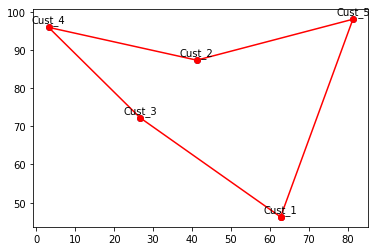


### Customer Info ###
Customer demands: [8, 8, 0, 8, 0]
First customer: Cust_1
Last customer: Cust_5
Depot-Node Distances: [('Depot_1', 0.0), ('Cust_1', 13.3), ('Cust_2', 38.3), ('Cust_3', 32.2), ('Cust_4', 65.6), ('Cust_5', 57.4)]

### Flexibility Designs [Circular Cost, Radial Cost, Total Cost, Number of Trips] ###
Primary Routes: [ 65. 128. 194.   2.]
Overlapped Routes: [ 65. 128. 194.   2.]
Full Flexibility Routes: [ 65. 128. 194.   2.]
Lower Bound: 67.0

 Note: Uncomment report sections in individual code blocks to see additional route and cost details.


In [77]:
##### COSTS #####

#print('### TSP ###')
obj, X, runtime = solve_Concorde_TSP(customers)
tau = get_sequence(customers, X)
#print('Total Cost: %g' % obj) 
#print('Runtime: %g' % runtime) 
plot_TSP(customers,X,True)

print('\n### Customer Info ###')
print('Customer demands:', [tau[i].d for i in tau])
print('First customer:', tau[list(tau.keys())[0]].ID)
print('Last customer:', tau[list(tau.keys())[-1]].ID)

print('Depot-Node Distances:', [(e[1], np.round(distances[e],1)) for e in distances if e[0]=='Depot_1'])

print('\n### Flexibility Designs [Circular Cost, Radial Cost, Total Cost, Number of Trips] ###')
print('Primary Routes:', np.round(solve_primary(tau, customers, my_depot, Q, route_size)))
print('Overlapped Routes:', np.round(solve_overlapped(tau, customers, my_depot, Q, route_size)))
print('Full Flexibility Routes:', np.round(solve_fully_flexible(tau, customers, my_depot, Q)))
print('Lower Bound:', np.round(get_lowerbound(customers, my_depot, Q)))
print("\n Note: Uncomment report sections in individual code blocks to see additional route and cost details.")

## Rotating Routes

In [34]:
def get_best_tour(X, custs, depot, Q, route_size, d_min, d_max, dem_sims):
             
    cumul_costs = np.zeros(len(custs))
    taulist = []

    # Get sequence from intial TSP solution
    first_tau = get_sequence(custs,X)
    taulist.append(first_tau)
    
    # Get cumulative cost across all demand instances for first rotation
    random.seed(0)
    for j in range(dem_sims):
        for cust in custs:
            #custs[cust].d = random.randint(d_min,d_max)
            custs[cust].d = random.choice([d_min,d_max])

        cumul_costs[0] += solve_overlapped(first_tau, custs, depot, Q, route_size)[2]

    # Rotate and find cumulative costs across all demand sims
    rotated_tau = first_tau

    for r in range(1,len(custs)):
        rotated_customers = list(rotated_tau.values())[1:] + [list(rotated_tau.values())[0]]
        rotated_tau = dict([(c, rotated_customers[i]) for c,i in zip(first_tau,range(len(first_tau)))])
        taulist.append(rotated_tau)
        random.seed(0)
        for j in range(dem_sims):
            for cust in custs:
                #custs[cust].d = random.randint(d_min,d_max)
                custs[cust].d = random.choice([d_min,d_max])
            cumul_costs[r] += solve_overlapped(rotated_tau, custs, depot, Q, route_size)[2]

    best_r = np.argmin(cumul_costs)
    return taulist[best_r]

## Simulation

#### Parameters

In [35]:
route_size = 5 # Number of customers in fixed primary route
N_values = [5*m for m in [1]]
#N_values = [5*m for m in [1,2,4,8,16]]
#N_values = [80]
dem_sims = 200 # Number of demand instances per problem size
cust_sims = 500 # Number of customer instances per problem size
d_max = 8 # Maximum customer demand
d_min = 0 # Minimum customer demand
Q = 20 # Vehicle capacity
area_width = 100
area_height = 100

# Single centrally located depot
depots = dict([("Depot_1", Depot(ID = "Depot_1", x = 50, y = 50))])
my_depot = depots['Depot_1']

#### Option 1: WITH ROTATION

In [36]:
##### Initialize arrays for results #####

lowerbound_sims = np.zeros((len(N_values), cust_sims, dem_sims))
primary_sims = np.zeros((len(N_values), cust_sims, dem_sims, 4)) # For circular, radial, total, and trip count
overlapped_sims = np.zeros((len(N_values), cust_sims, dem_sims, 4))
full_flex_sims = np.zeros((len(N_values), cust_sims, dem_sims, 4))
SDVRP_sims = np.zeros((len(N_values), cust_sims, dem_sims,2)) # For total cost and trip count

##### Run simulation #####

for n in range(len(N_values)):
    print('Solving problems of size %s...' %N_values[n], flush=True)

    # Create customers
    random.seed(10)
    for i in range(cust_sims):
        random.seed(1000*N_values[n]*(i+1))
        print('Starting customer instance', i+1, '...', flush=True)

        # Generate set of N customers
        customers = dict([('Cust_'+str(c+1),
                           Customer(ID = 'Cust_'+str(c+1),
                                    x = random.uniform(0,area_width),
                                    y = random.uniform(0,area_height),
                                    d = random.choice([d_min,d_max])))
                                    #d = random.randint(d_min,d_max)))
                          for c in range(N_values[n])])
        
        # Get tour
        obj, X, runtime = solve_Concorde_TSP(customers)
        tau = get_best_tour(X, customers, my_depot, Q, route_size, d_min, d_max, dem_sims)

        # Demand simulations
        random.seed(0)
        for j in range(dem_sims):          
           
            # Update customer demands
            for cust in customers:   
                #customers[cust].d = random.randint(d_min,d_max)
                customers[cust].d = random.choice([d_min,d_max])

            # Solve network models
            lowerbound_sims[n,i,j] = get_lowerbound(customers, my_depot, Q)
            primary_sims[n,i,j,:] = solve_primary(tau, customers, my_depot, Q, route_size)
            overlapped_sims[n,i,j,:] = solve_overlapped(tau, customers, my_depot, Q, route_size)
            full_flex_sims[n,i,j,:] = solve_fully_flexible(tau, customers, my_depot, Q)

            # SDVRP route costs
            demand_points = get_demand_points(customers)
            obj, runtime, num_trips = solve_OR_Tools_VRP(demand_points, depots, Q)
            SDVRP_sims[n,i,j,:] = (obj, num_trips)
            #print('SDVRP completed in %s seconds' %np.round(runtime,2), flush=True)
            
print('Complete.')

Solving problems of size 5...
Starting customer instance 1 ...
Starting customer instance 2 ...
Starting customer instance 3 ...
Starting customer instance 4 ...
Starting customer instance 5 ...
Starting customer instance 6 ...
Starting customer instance 7 ...
Starting customer instance 8 ...
Starting customer instance 9 ...
Starting customer instance 10 ...
Starting customer instance 11 ...
Starting customer instance 12 ...
Starting customer instance 13 ...
Starting customer instance 14 ...
Starting customer instance 15 ...
Starting customer instance 16 ...
Starting customer instance 17 ...
Starting customer instance 18 ...
Starting customer instance 19 ...
Starting customer instance 20 ...
Starting customer instance 21 ...
Starting customer instance 22 ...
Starting customer instance 23 ...
Starting customer instance 24 ...
Starting customer instance 25 ...
Starting customer instance 26 ...
Starting customer instance 27 ...
Starting customer instance 28 ...
Starting customer instance 

#### Option 2: WITHOUT ROTATION

In [85]:
##### Initialize arrays for results #####

lowerbound_sims = np.zeros((len(N_values), cust_sims, dem_sims))
primary_sims = np.zeros((len(N_values), cust_sims, dem_sims, 4)) # For circular, radial, total, and trip count
overlapped_sims = np.zeros((len(N_values), cust_sims, dem_sims, 4))
full_flex_sims = np.zeros((len(N_values), cust_sims, dem_sims, 4))
SDVRP_sims = np.zeros((len(N_values), cust_sims, dem_sims,2)) # For total cost and trip count

##### Run simulation #####

for n in range(len(N_values)):
    print('Solving problems of size %s...' %N_values[n], flush=True)

    # Create customers
    for i in range(cust_sims):
        random.seed(1000*N_values[n]*(i+1))
        print('Starting customer instance', i+1, '...', flush=True)

        # Generate set of N customers
        customers = dict([('Cust_'+str(c+1),
                           Customer(ID = 'Cust_'+str(c+1),
                                    x = random.uniform(0,area_width),
                                    y = random.uniform(0,area_height),
                                    d = random.choice([d_min,d_max])))
                                    #d = random.randint(d_min,d_max)))
                          for c in range(N_values[n])])
        
        # Get tour
        obj, X, runtime = solve_Concorde_TSP(customers)
        tau = get_sequence(customers,X)

        # Demand simulations
        random.seed(0)
        for j in range(dem_sims):          
           
            # Update customer demands
            for cust in customers:   
                #customers[cust].d = random.randint(d_min,d_max)
                customers[cust].d = random.choice([d_min,d_max])
            
            # Solve network models
            lowerbound_sims[n,i,j] = get_lowerbound(customers, my_depot, Q)
            primary_sims[n,i,j,:] = solve_primary(tau, customers, my_depot, Q, route_size)
            overlapped_sims[n,i,j,:] = solve_overlapped(tau, customers, my_depot, Q, route_size)
            full_flex_sims[n,i,j,:] = solve_fully_flexible(tau, customers, my_depot, Q)

            # SDVRP route costs
            demand_points = get_demand_points(customers)
            obj, runtime, num_trips = solve_OR_Tools_VRP(demand_points, depots, Q)
            SDVRP_sims[n,i,j,:] = (obj, num_trips)
            #print('SDVRP completed in %s seconds' %np.round(runtime,2), flush=True)
            
print('Complete.')

Solving problems of size 5...
Starting customer instance 1 ...
Starting customer instance 2 ...
Starting customer instance 3 ...
Solving problems of size 10...
Starting customer instance 1 ...
Starting customer instance 2 ...
Starting customer instance 3 ...
Solving problems of size 20...
Starting customer instance 1 ...
Starting customer instance 2 ...
Starting customer instance 3 ...
Solving problems of size 40...
Starting customer instance 1 ...
Starting customer instance 2 ...
Starting customer instance 3 ...
Solving problems of size 80...
Starting customer instance 1 ...
Starting customer instance 2 ...
Starting customer instance 3 ...
Complete.


Summarize and export data

In [37]:
primary = pd.DataFrame(np.mean(primary_sims, axis=(1,2)), columns=['Circular','Radial','Total','Trips'])
overlapped = pd.DataFrame(np.mean(overlapped_sims, axis=(1,2)), columns=['Circular', 'Radial','Total','Trips'])
full_flex = pd.DataFrame(np.mean(full_flex_sims, axis=(1,2)), columns=['Circular', 'Radial','Total','Trips'])
lowerbound = pd.DataFrame(np.mean(lowerbound_sims, axis=(1,2)), columns=['Total'])
SDVRP = pd.DataFrame(np.mean(SDVRP_sims, axis=(1,2)), columns=['Total','Trips'])

combined = pd.concat([primary,overlapped,full_flex,SDVRP,lowerbound], axis=1,
                     keys = ['Primary','Overlapped','Full Flexibility','Reoptimization','Lowerbound'])
combined['N'] = N_values
combined['M'] = np.divide(N_values,route_size).astype(int)
combined.to_excel('output/test/Comb_stochCust_M1.xlsx')
combined.round(3)

Primary                        Overlapped                         \
  Circular  Radial   Total  Trips   Circular  Radial   Total  Trips   
0    70.58  104.78  175.36  1.455      70.58  104.78  175.36  1.455   

  Full Flexibility                        Reoptimization       Lowerbound  N  \
          Circular  Radial   Total  Trips          Total Trips      Total      
0            70.58  104.78  175.36  1.455        152.769  1.47     75.951  5   

   M  
      
0  1

#### Import and combine data (if needed)

In [38]:
route_size= 5
df = []
df.append(pd.read_excel('output/Comb_stochCust_M1-2-4.xlsx', header=(0,1), index_col=0))
df.append(pd.read_excel('output/Comb_stochCust_M8.xlsx', header=(0,1), index_col=0))
df.append(pd.read_excel('output/Comb_stochCust_M16.xlsx', header=(0,1), index_col=0))
combined = pd.concat(df, axis=0, ignore_index=True)
combined = combined.drop(labels=['N','M'], axis=1)
M_values = [1,2,4,8,16]
combined['M'] = M_values
combined['N'] = np.multiply(M_values,route_size).astype(int)
combined.to_excel('output/Comb_stochCust.xlsx')
combined

Primary                                     Overlapped               \
     Circular       Radial        Total    Trips    Circular       Radial   
0   70.122576   102.390661   172.513237   1.4710   70.122576   102.390661   
1  106.121535   221.424343   327.545878   2.9264  133.183655   182.002098   
2  142.958057   424.206430   567.164488   5.8380  201.097154   315.625463   
3  198.021572   889.946519  1087.968091  11.6891  288.400811   632.721634   
4  268.908078  1787.797837  2056.705914  23.3789  394.585957  1261.321803   

                        Full Flexibility                                    \
         Total    Trips         Circular       Radial        Total   Trips   
0   172.513237   1.4710        70.122576   102.390661   172.513237   1.471   
1   315.185753   2.3670       133.183655   182.002098   315.185753   2.367   
2   516.722617   4.4398       207.837396   310.862164   518.699560   4.377   
3   921.122444   8.5501       301.816781   616.685699   918.502480   8.362   
4  1655.907760  16.7451       416.344804  1225.025356  1641.370159  16.305   

  Reoptimization            Lowerbound   M   N  
           Total    Trips        Total          
0       150.3159   1.4739    75.554095   1   5  
1       289.0170   2.3777   156.575980   2  10  
2       488.2939   4.3843   295.007422   4  20  
3       885.0214   8.3725   603.035424   8  40  
4      1601.9380  16.3144  1215.048697  16  80

#### Summary plots

In [20]:
combined = pd.read_excel('output/Comb_May5.xlsx', header=(0,1))
combined = combined.drop(labels=['N','M'], axis=1)
combined = combined.drop(combined.columns[0], axis=1)
M_values = [1,2,4,8,16]
combined['M'] = M_values
route_size = 5
combined['N'] = np.multiply(M_values,route_size).astype(int)
combined

Primary                                     Overlapped               \
     Circular       Radial        Total    Trips    Circular       Radial   
0  132.578684    92.628350   225.207034   1.4780  132.578684    92.628350   
1  189.515653   203.565057   393.080709   2.9059  207.101472   174.865164   
2  274.805259   394.631042   669.436302   5.8133  317.689472   299.352922   
3  356.837213   867.345969  1224.183182  11.6769  443.062196   623.318123   
4  473.881988  1790.355763  2264.237751  23.3451  601.708769  1248.983229   

                        Full Flexibility                                    \
         Total    Trips         Circular       Radial        Total   Trips   
0   225.207034   1.4780       132.578684    92.628350   225.207034   1.478   
1   381.966637   2.4430       207.101472   174.865164   381.966637   2.443   
2   617.042395   4.4883       321.583261   297.433000   619.016261   4.447   
3  1066.380319   8.5688       451.790520   613.617629  1065.408149   8.451   
4  1850.691998  16.6501       615.946836  1227.477443  1843.424279  16.381   

  Reoptimization            Lowerbound   M   N  
           Total    Trips        Total          
0       202.7782   1.4798    75.118785   1   5  
1       338.4464   2.4432   153.034745   2  10  
2       566.4613   4.4546   293.653499   4  20  
3       991.4582   8.4566   606.214353   8  40  
4      1755.1273  16.3861  1224.042500  16  80

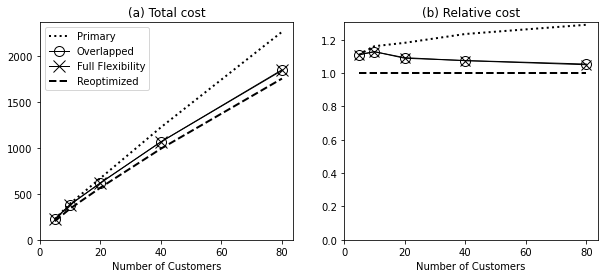

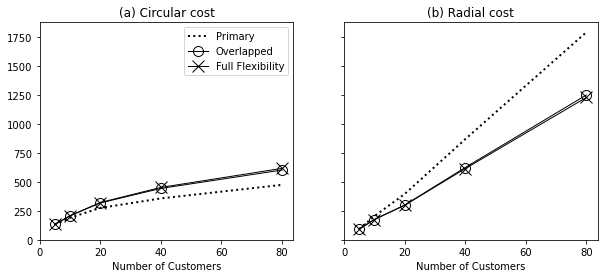

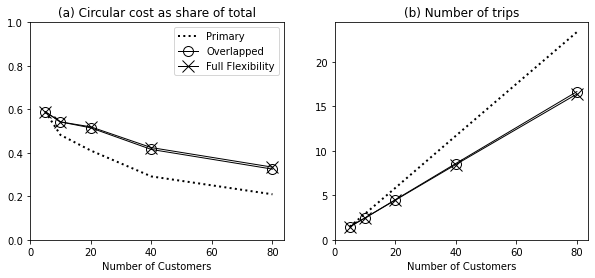

In [28]:
N_values = [5*m for m in [1,2,4,8,16]]

##### Total & Relative Cost #####

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

ax1.plot(N_values, combined['Primary']['Total'], 'k', label='Primary', linewidth=2, linestyle='dotted', marker='')
ax1.plot(N_values, combined['Overlapped']['Total'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1, fillstyle='none')
ax1.plot(N_values, combined['Full Flexibility']['Total'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
ax1.plot(N_values, combined['Reoptimization']['Total'], 'k', label='Reoptimized', linewidth=2, linestyle='dashed')
#ax1.plot(N_values, combined['Lowerbound']['Total'], 'k', label='Lowerbound', linewidth=2)
ax1.set_title('(a) Total cost')
#ax.set_ylabel('Cost')

ax2.plot(N_values, combined['Primary']['Total'] / combined['Reoptimization']['Total'], 'k', label='Primary', linewidth=2, linestyle='dotted')
ax2.plot(N_values, combined['Overlapped']['Total'] / combined['Reoptimization']['Total'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1,  fillstyle='none')
ax2.plot(N_values, combined['Full Flexibility']['Total'] / combined['Reoptimization']['Total'], 'k', label='Full Flexibility', linewidth=1, markersize=10, marker='x')
ax2.plot(N_values, combined['Reoptimization']['Total'] / combined['Reoptimization']['Total'], 'k', label= 'Reoptimized', linewidth=2, linestyle='dashed')
#ax2.plot(N_values, combined['Lowerbound']['Total'] / combined['Reoptimization']['Total'], 'k', label= 'Lowerbound', linewidth=2)
ax2.set_title('(b) Relative cost')
#ax2.set_ylabel('Relative Cost')

for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Number of Customers')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    
ax1.legend()
#plt.savefig('figures/total-combined.png')


##### Circular & Radial Cost #####

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.plot(N_values, combined['Primary']['Circular'], 'k', label='Primary', linewidth=2, linestyle='dotted', marker='')
ax1.plot(N_values, combined['Overlapped']['Circular'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1,  fillstyle='none')
ax1.plot(N_values, combined['Full Flexibility']['Circular'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
ax1.set_title('(a) Circular cost')

ax2.plot(N_values, combined['Primary']['Radial'], 'k', label='Primary', linewidth=2, linestyle='dotted', marker='')
ax2.plot(N_values, combined['Overlapped']['Radial'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1,  fillstyle='none')
ax2.plot(N_values, combined['Full Flexibility']['Radial'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
ax2.set_title('(b) Radial cost')

for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Number of Customers')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

ax1.legend()
#plt.savefig(path+'cost-breakdown'+label+'.png')


##### Trip Count & Circular Ratio #####


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

ax1.plot(N_values, combined['Primary']['Circular'] / combined['Primary']['Total'], 'k', label='Primary', linewidth=2, linestyle='dotted')
ax1.plot(N_values, combined['Overlapped']['Circular'] / combined['Overlapped']['Total'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1,  fillstyle='none')
ax1.plot(N_values, combined['Full Flexibility']['Circular'] / combined['Full Flexibility']['Total'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
ax1.set_ylim(top=1)
ax1.set_title('(a) Circular cost as share of total')

ax2.plot(N_values, combined['Primary']['Trips'], 'k', label='Primary', linewidth=2, linestyle='dotted', marker='')
ax2.plot(N_values, combined['Overlapped']['Trips'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1, fillstyle='none')
ax2.plot(N_values, combined['Full Flexibility']['Trips'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
#ax2.plot(N_values, combined['Reoptimization']['Trips'], 'k', label='Reoptimized', linewidth=2, linestyle='dashed')
ax2.set_title('(b) Number of trips')


for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Number of Customers')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    #ax.legend()

ax1.legend()
plt.savefig('figures/trips-circular-combined.png')


In [ ]:

###---------- OLD -----------------###
##### Trip Count #####

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=False)

ax.plot(N_values, combined['Primary']['Trips'], 'k', label='Primary', linewidth=2, linestyle='dotted', marker='')
ax.plot(N_values, combined['Overlapped']['Trips'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1, fillstyle='none')
ax.plot(N_values, combined['Full Flexibility']['Trips'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
#ax.plot(N_values, combined['Reoptimization']['Trips'], 'k', label='Reoptimized', linewidth=2, linestyle='dashed')
#ax.set_title('Trip Count')
ax.set_ylabel('Number of Trips')

for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Number of Customers')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    
plt.legend()
plt.savefig('figures/trips.png')



##### Circular Cost Ratio #####

fig, ax1 = plt.subplots(1, 1, figsize=(6,4), sharey=False)

ax1.plot(N_values, combined['Primary']['Circular'] / combined['Primary']['Total'], 'k', label='Primary', linewidth=2, linestyle='dotted')
ax1.plot(N_values, combined['Overlapped']['Circular'] / combined['Overlapped']['Total'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1,  fillstyle='none')
ax1.plot(N_values, combined['Full Flexibility']['Circular'] / combined['Full Flexibility']['Total'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
#ax1.set_title('Circular Cost as Share of Total Cost')
ax1.set_ylim(top=1)
ax1.set_ylabel('Share of Total Cost')

for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Number of Customers')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.legend()

#plt.savefig(path+'circular-ratio'+label+'.png')

##### Total & relative cost (individual figures) #####

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=False)

ax.plot(N_values, combined['Primary']['Total'], 'k', label='Primary', linewidth=2, linestyle='dotted', marker='')
ax.plot(N_values, combined['Overlapped']['Total'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1, fillstyle='none')
ax.plot(N_values, combined['Full Flexibility']['Total'], 'k', label='Full Flexibility', linewidth=1, markersize=12, marker='x')
ax.plot(N_values, combined['Reoptimization']['Total'], 'k', label='Reoptimized', linewidth=2, linestyle='dashed')
ax.plot(N_values, combined['Lowerbound']['Total'], 'k', label='Lowerbound', linewidth=2)
#ax.set_title('Total Cost')
#ax.set_ylabel('Cost')

for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Number of Customers')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    
plt.legend()
#plt.savefig(path+'total-cost'+label+'.png')


fig, ax2 = plt.subplots(1, 1, figsize=(6,4), sharey=False)

ax2.plot(N_values, combined['Primary']['Total'] / combined['Reoptimization']['Total'], 'k', label='Primary', linewidth=2, linestyle='dotted')
ax2.plot(N_values, combined['Overlapped']['Total'] / combined['Reoptimization']['Total'], 'k', label='Overlapped', marker='o', markersize=10, linewidth=1,  fillstyle='none')
ax2.plot(N_values, combined['Full Flexibility']['Total'] / combined['Reoptimization']['Total'], 'k', label='Full Flexibility', linewidth=1, markersize=10, marker='x')
ax2.plot(N_values, combined['Reoptimization']['Total'] / combined['Reoptimization']['Total'], 'k', label= 'Reoptimized', linewidth=2, linestyle='dashed')
ax2.plot(N_values, combined['Lowerbound']['Total'] / combined['Reoptimization']['Total'], 'k', label= 'Lowerbound', linewidth=2)
#ax2.set_title('Overlapped Total Cost \n Relative to Other Recourse Strategies')
#ax2.set_ylabel('Relative Cost')

for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Number of Customers')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.legend()

#plt.savefig(path+'relative-cost'+label+'.png')